# Visual De-Animation Experiments
### by Jonathan Gustafsson Frennert

To evaluate our model, we apply it in four different settings:

1. __Predict Mass__:
    \begin{align}
    \forall j &= 1,2, \dots, n,\text{ we sample index } i \sim U\{1, 2, 3\} \\
    m(j) &= M(i), \quad r(j) = R(i)
    \end{align}
    Model should learn to associate higher mass $m$ with higher radius $r$. This configuration tests the feasibility of training the model to differentiate objects of various sizes.

2. __Predict Friction__:
    \begin{align}
    \forall j &= 1,2, \dots, n,\text{ we sample index } i \sim U\{1, 2\}, \\
    \mu_r(j) &= F(i)
    \end{align}
    Model should learn to associate change in position between images and magnitude of optical flow with $\mu_r$. This configuration tests the feasibility of training the model to differentiate objects by motion.

3. __Predict Material__:
    \begin{align}
    \forall j &= 1,2, \dots, n,\text{ we sample index } i \sim U\{1, 2, 3\}, k\sim U\{1, 2\}, \\
    m(j) &= M(i), \quad \mu_r(j) = F(k), \\
    \vec{c}(j) &= C(i \cdot k)
    \end{align}
    Model should learn to associate visual appearance with $m$ and $\mu_r$. This configuration tests the feasibility of training the model to differentiate objects by material (represented by colour).

4. __Predict Mass and Friction__:
    \begin{align}
    \forall j &= 1,2, \dots, n,\text{ we sample index } i \sim U\{1, 2, 3\}, k\sim U\{1, 2\}, \\
    m(j) &= M(i), \quad r(j) = R(i) \\
    \mu_r(j) &= F(k)
    \end{align}
    Model should learn to associate both higher $m$ with higher $r$ and change in position between images and magnitude of optical flow with $\mu_r$ independently. This configuration tests the feasibility of the model to differentiate objects by several uncorrelated factors.


### Imports

In [1]:
import glob
import os

import torch
import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Patch
from matplotlib.transforms import Affine2D
import warnings
warnings.filterwarnings('ignore')

print("All packages imported!")

All packages imported!


### Visualization

In [2]:
mpl.rcParams['figure.dpi'] = 500
mpl.rcParams['font.size'] = 9
# Latex document Text width
latex_width = 452.9679

def set_size(width=latex_width, height=latex_width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.
    
    Credit to Jack Walton for the function.
    Source: https://jwalton.info/Embed-Publication-Matplotlib-Latex/
    """

    fig_width_pt = width * fraction
    fig_height_pt = height * fraction
    
    inches_per_pt = 1 / 72.27
    
    fig_width_in = fig_width_pt * inches_per_pt
    fig_height_in = fig_height_pt * inches_per_pt * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

colors = [
    "#ba4c40",
    "#45c097",
    "#573485",
    "#a8ae3e",
    "#8874d9",
    "#69a050",
    "#be64b2",
    "#bc7d36",
    "#5d8ad4",
    "#b94973"
]

markers = ['v', 's', 'o', 'D', '^']

## 1. Predict Mass

In [3]:
pm_far_fp = os.path.join(os.getcwd(), 'ckpt', 'predict_mass-farneback-resnet18-pybullet', 'eval_epoch_5.pth')
pm_spy_fp = os.path.join(os.getcwd(), 'ckpt', 'predict_mass-spynet-resnet18-pybullet', 'eval_epoch_5.pth')


pm_far = torch.load(pm_far_fp)
pm_spy = torch.load(pm_spy_fp)

## 2. Predict Friction

In [4]:
pf_far_fp = os.path.join(os.getcwd(), 'ckpt', 'predict_friction-farneback-resnet18-pybullet', 'eval_epoch_5.pth')
pf_spy_fp = os.path.join(os.getcwd(), 'ckpt', 'predict_friction-spynet-resnet18-pybullet', 'eval_epoch_5.pth')
opt_pf_far_fp = os.path.join(os.getcwd(), 'ckpt', 'optical_flow_only-predict_friction-farneback-resnet18-pybullet', 'eval_epoch_5.pth')
opt_pf_spy_fp = os.path.join(os.getcwd(), 'ckpt', 'optical_flow_only-predict_friction-spynet-resnet18-pybullet', 'eval_epoch_5.pth')
img_pf_fp = os.path.join(os.getcwd(), 'ckpt', 'images_only-predict_friction-farneback-resnet18-pybullet', 'eval_epoch_5.pth')

pf_far = torch.load(pf_far_fp)
pf_spy = torch.load(pf_spy_fp)
opt_pf_far = torch.load(opt_pf_far_fp)
opt_pf_spy = torch.load(opt_pf_spy_fp)
img_pf = torch.load(img_pf_fp)

## 3. Predict Material

In [5]:
pmfd_far_fp = os.path.join(os.getcwd(), 'ckpt', 'predict_friction_mass_dependent-farneback-resnet18-pybullet', 'eval_epoch_5.pth')
pmfd_spy_fp = os.path.join(os.getcwd(), 'ckpt', 'predict_friction_mass_dependent-spynet-resnet18-pybullet', 'eval_epoch_5.pth')

pmfd_far = torch.load(pmfd_far_fp)
pmfd_spy = torch.load(pmfd_spy_fp)

## 4. Predict Mass and Friction

In [6]:
pmfi_far_fp = os.path.join(os.getcwd(), 'ckpt', 'predict_friction_mass_independent-farneback-resnet18-pybullet', 'eval_epoch_5.pth')
pmfi_spy_fp = os.path.join(os.getcwd(), 'ckpt', 'predict_friction_mass_independent-spynet-resnet18-pybullet', 'eval_epoch_5.pth')

pmfi_far = torch.load(pmfi_far_fp)
pmfi_spy = torch.load(pmfi_spy_fp)

## Main Prediction plots

<Figure size 3000x2000 with 0 Axes>

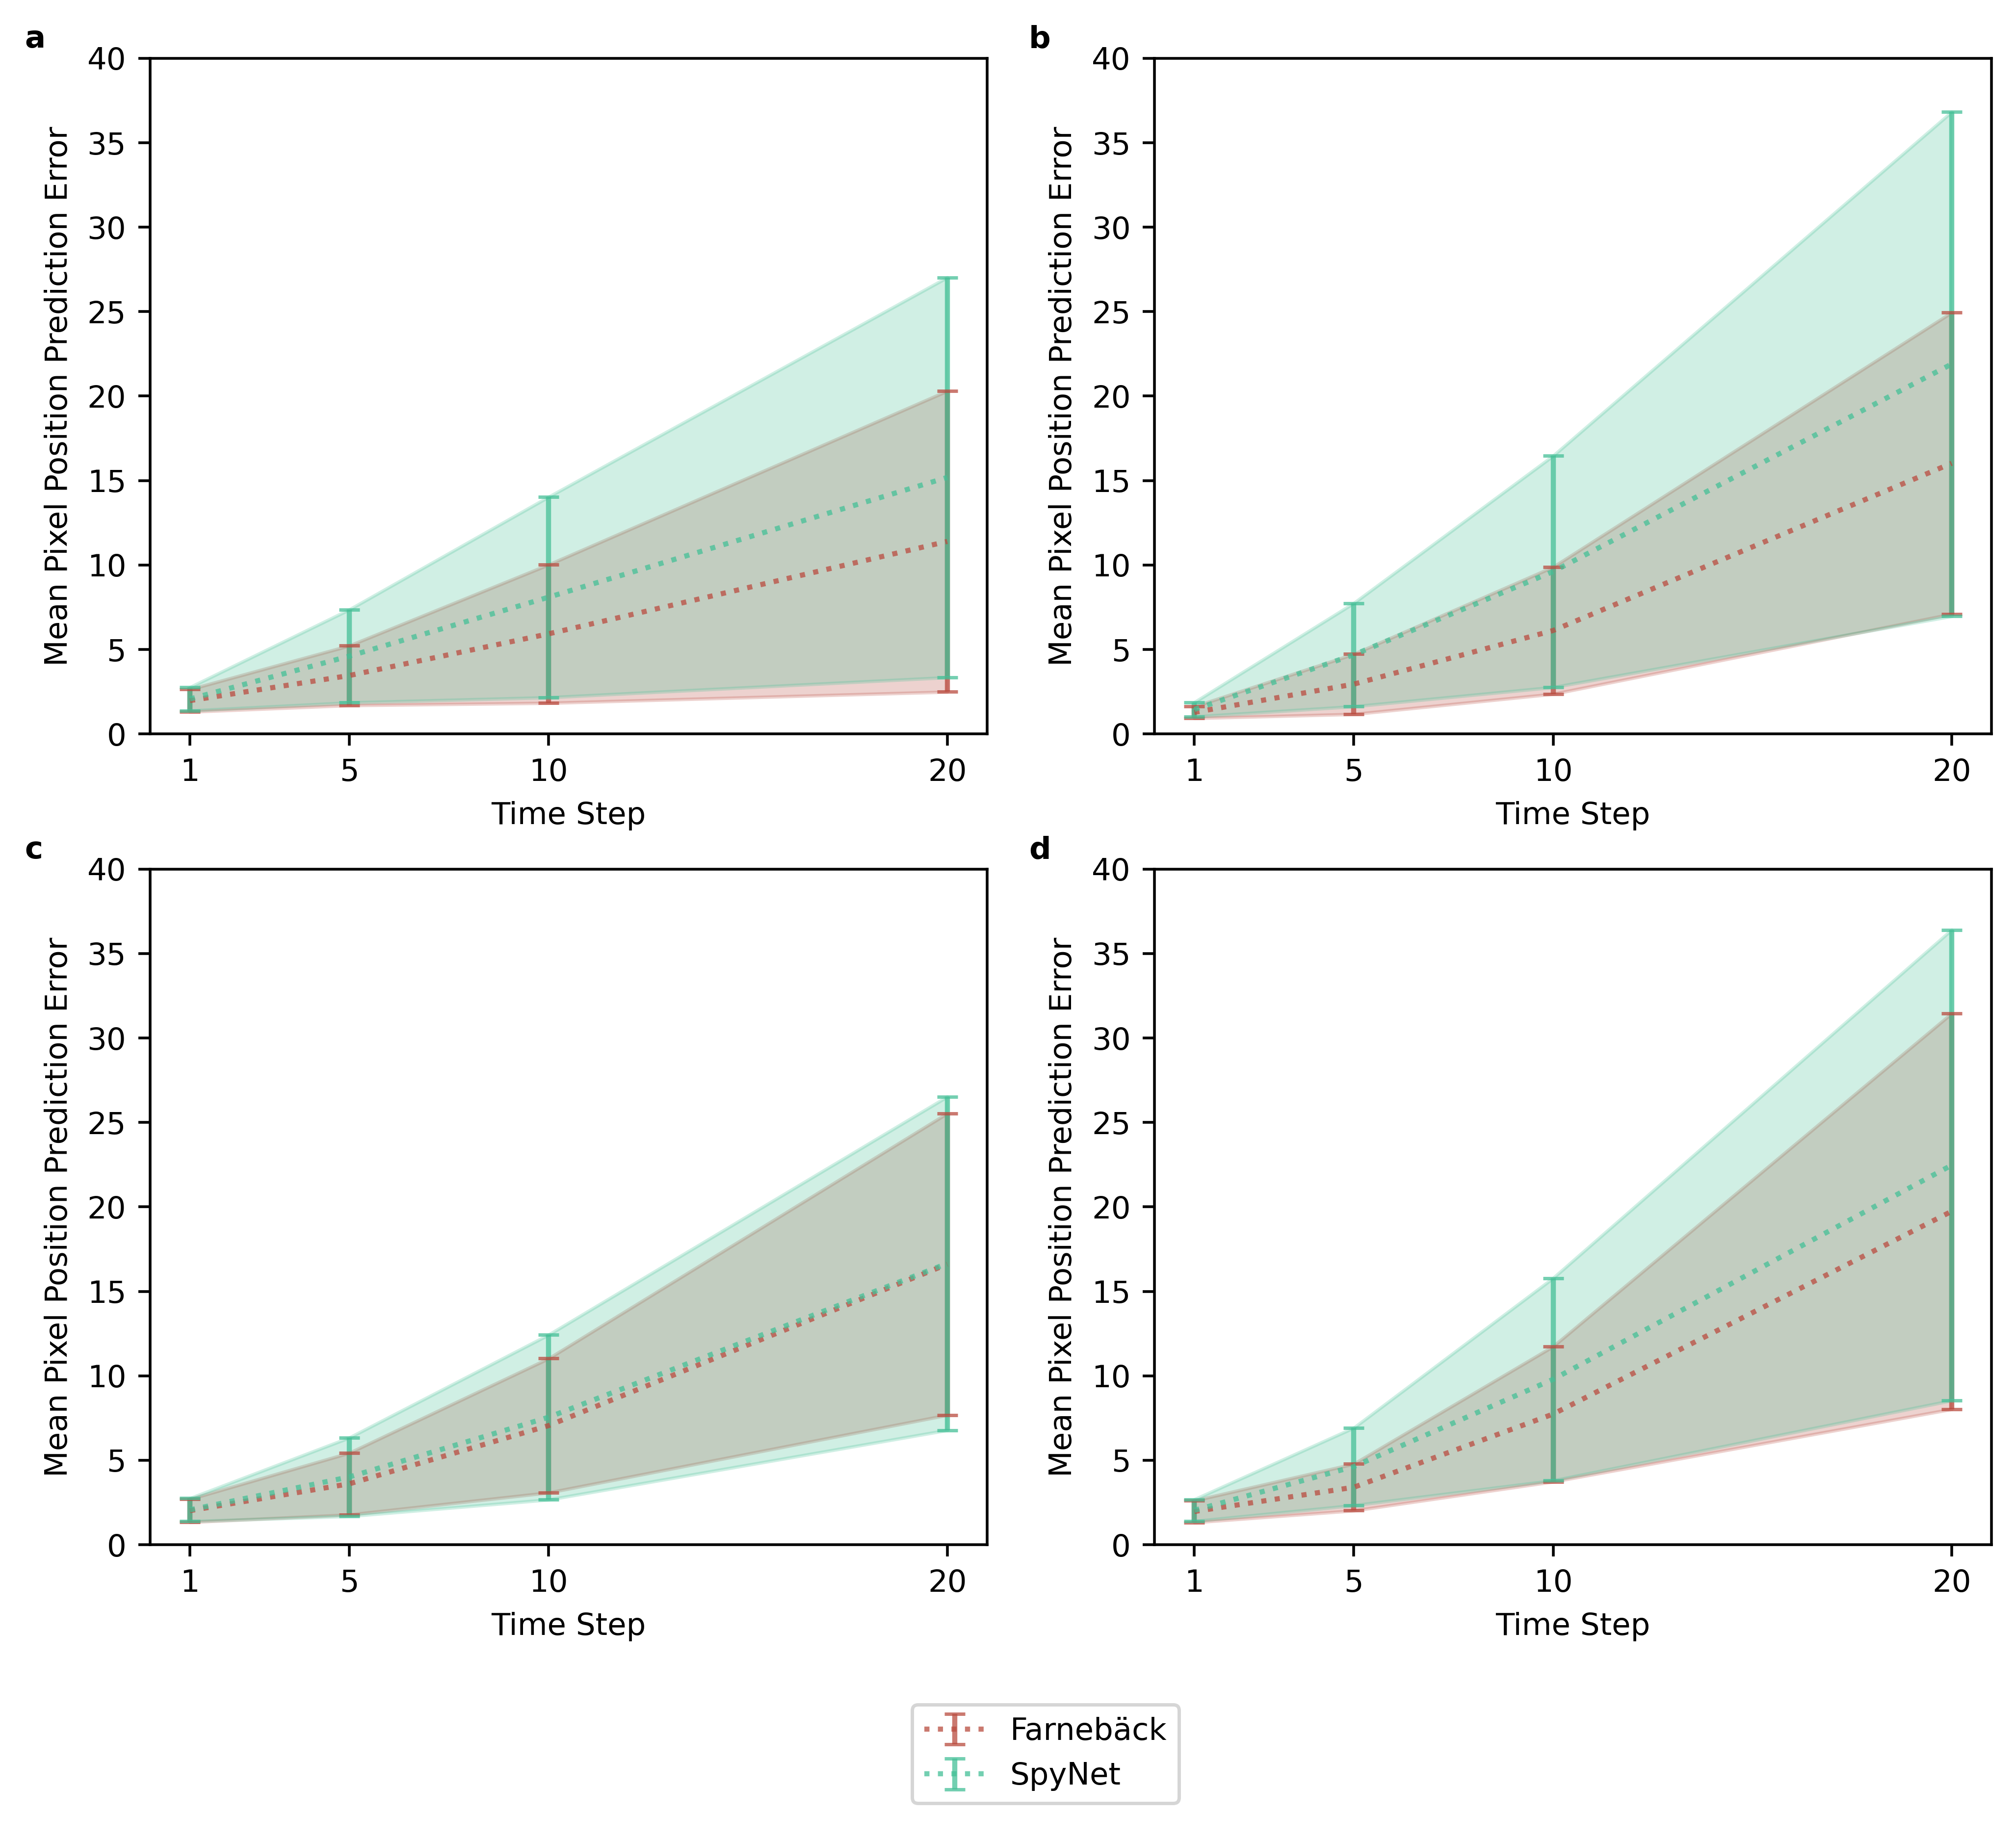

In [7]:
plt.clf()
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=set_size(subplots=(2, 2), width=700, height=600), constrained_layout=True)

plots = [ax1,ax2,ax3,ax4]
ys = [[pm_far, pm_spy], 
          [pf_far, pf_spy], 
          [pmfd_far, pmfd_spy], 
          [pmfi_far, pmfi_spy]]
x = [1,5,10,20]

options = ['Farnebäck', 'SpyNet']

for i in range(4):
    ax = plots[i]
    trans = [Affine2D().translate(-1, 0.0) + ax.transData, Affine2D().translate(+1, 0.0) + ax.transData]
    for j in range(2):
        y = ys[i][j]['pred_pos_ave'][:4]
        e = ys[i][j]['pred_pos_std'][:4]
        #ax.errorbar(x,  y, e, marker=markers[j], label=options[j], color=colors[j], capsize=5, transform=trans[j], linestyle="none")
        ax.errorbar(x,  y, e, label=options[j], color=colors[j], alpha=.75, fmt=':', capsize=3, capthick=1)
        data = {
        'x': x,
        'y1': [y1 - e1 for y1, e1 in zip(y, e)],
        'y2': [y1 + e1 for y1, e1 in zip(y, e)]}
        ax.fill_between(**data, alpha=.25, color=colors[j])
        ax.legend().remove()
        ax.margins(1)
        ax.set_xlim(0,21)
        ax.set_xticks(x)
        ax.set_ylim(0,40)
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Mean Pixel Position Prediction Error')
        
ax1.text(-0.15, 1.05, 'a', transform=ax1.transAxes, fontweight='bold', va='top')
ax2.text(-0.15, 1.05, 'b', transform=ax2.transAxes, fontweight='bold', va='top')
ax3.text(-0.15, 1.05, 'c', transform=ax3.transAxes, fontweight='bold', va='top')
ax4.text(-0.15, 1.05, 'd', transform=ax4.transAxes, fontweight='bold', va='top')

h1, l1 = ax1.get_legend_handles_labels()
fig.legend(handles=h1, labels=l1, loc='lower center', bbox_to_anchor=(0.44,0.01))
fig.subplots_adjust(bottom=0.15)


#plt.savefig('fig_main_pos_plot.pdf', format='pdf', bbox_inches='tight')

plt.show()

<Figure size 3000x2000 with 0 Axes>

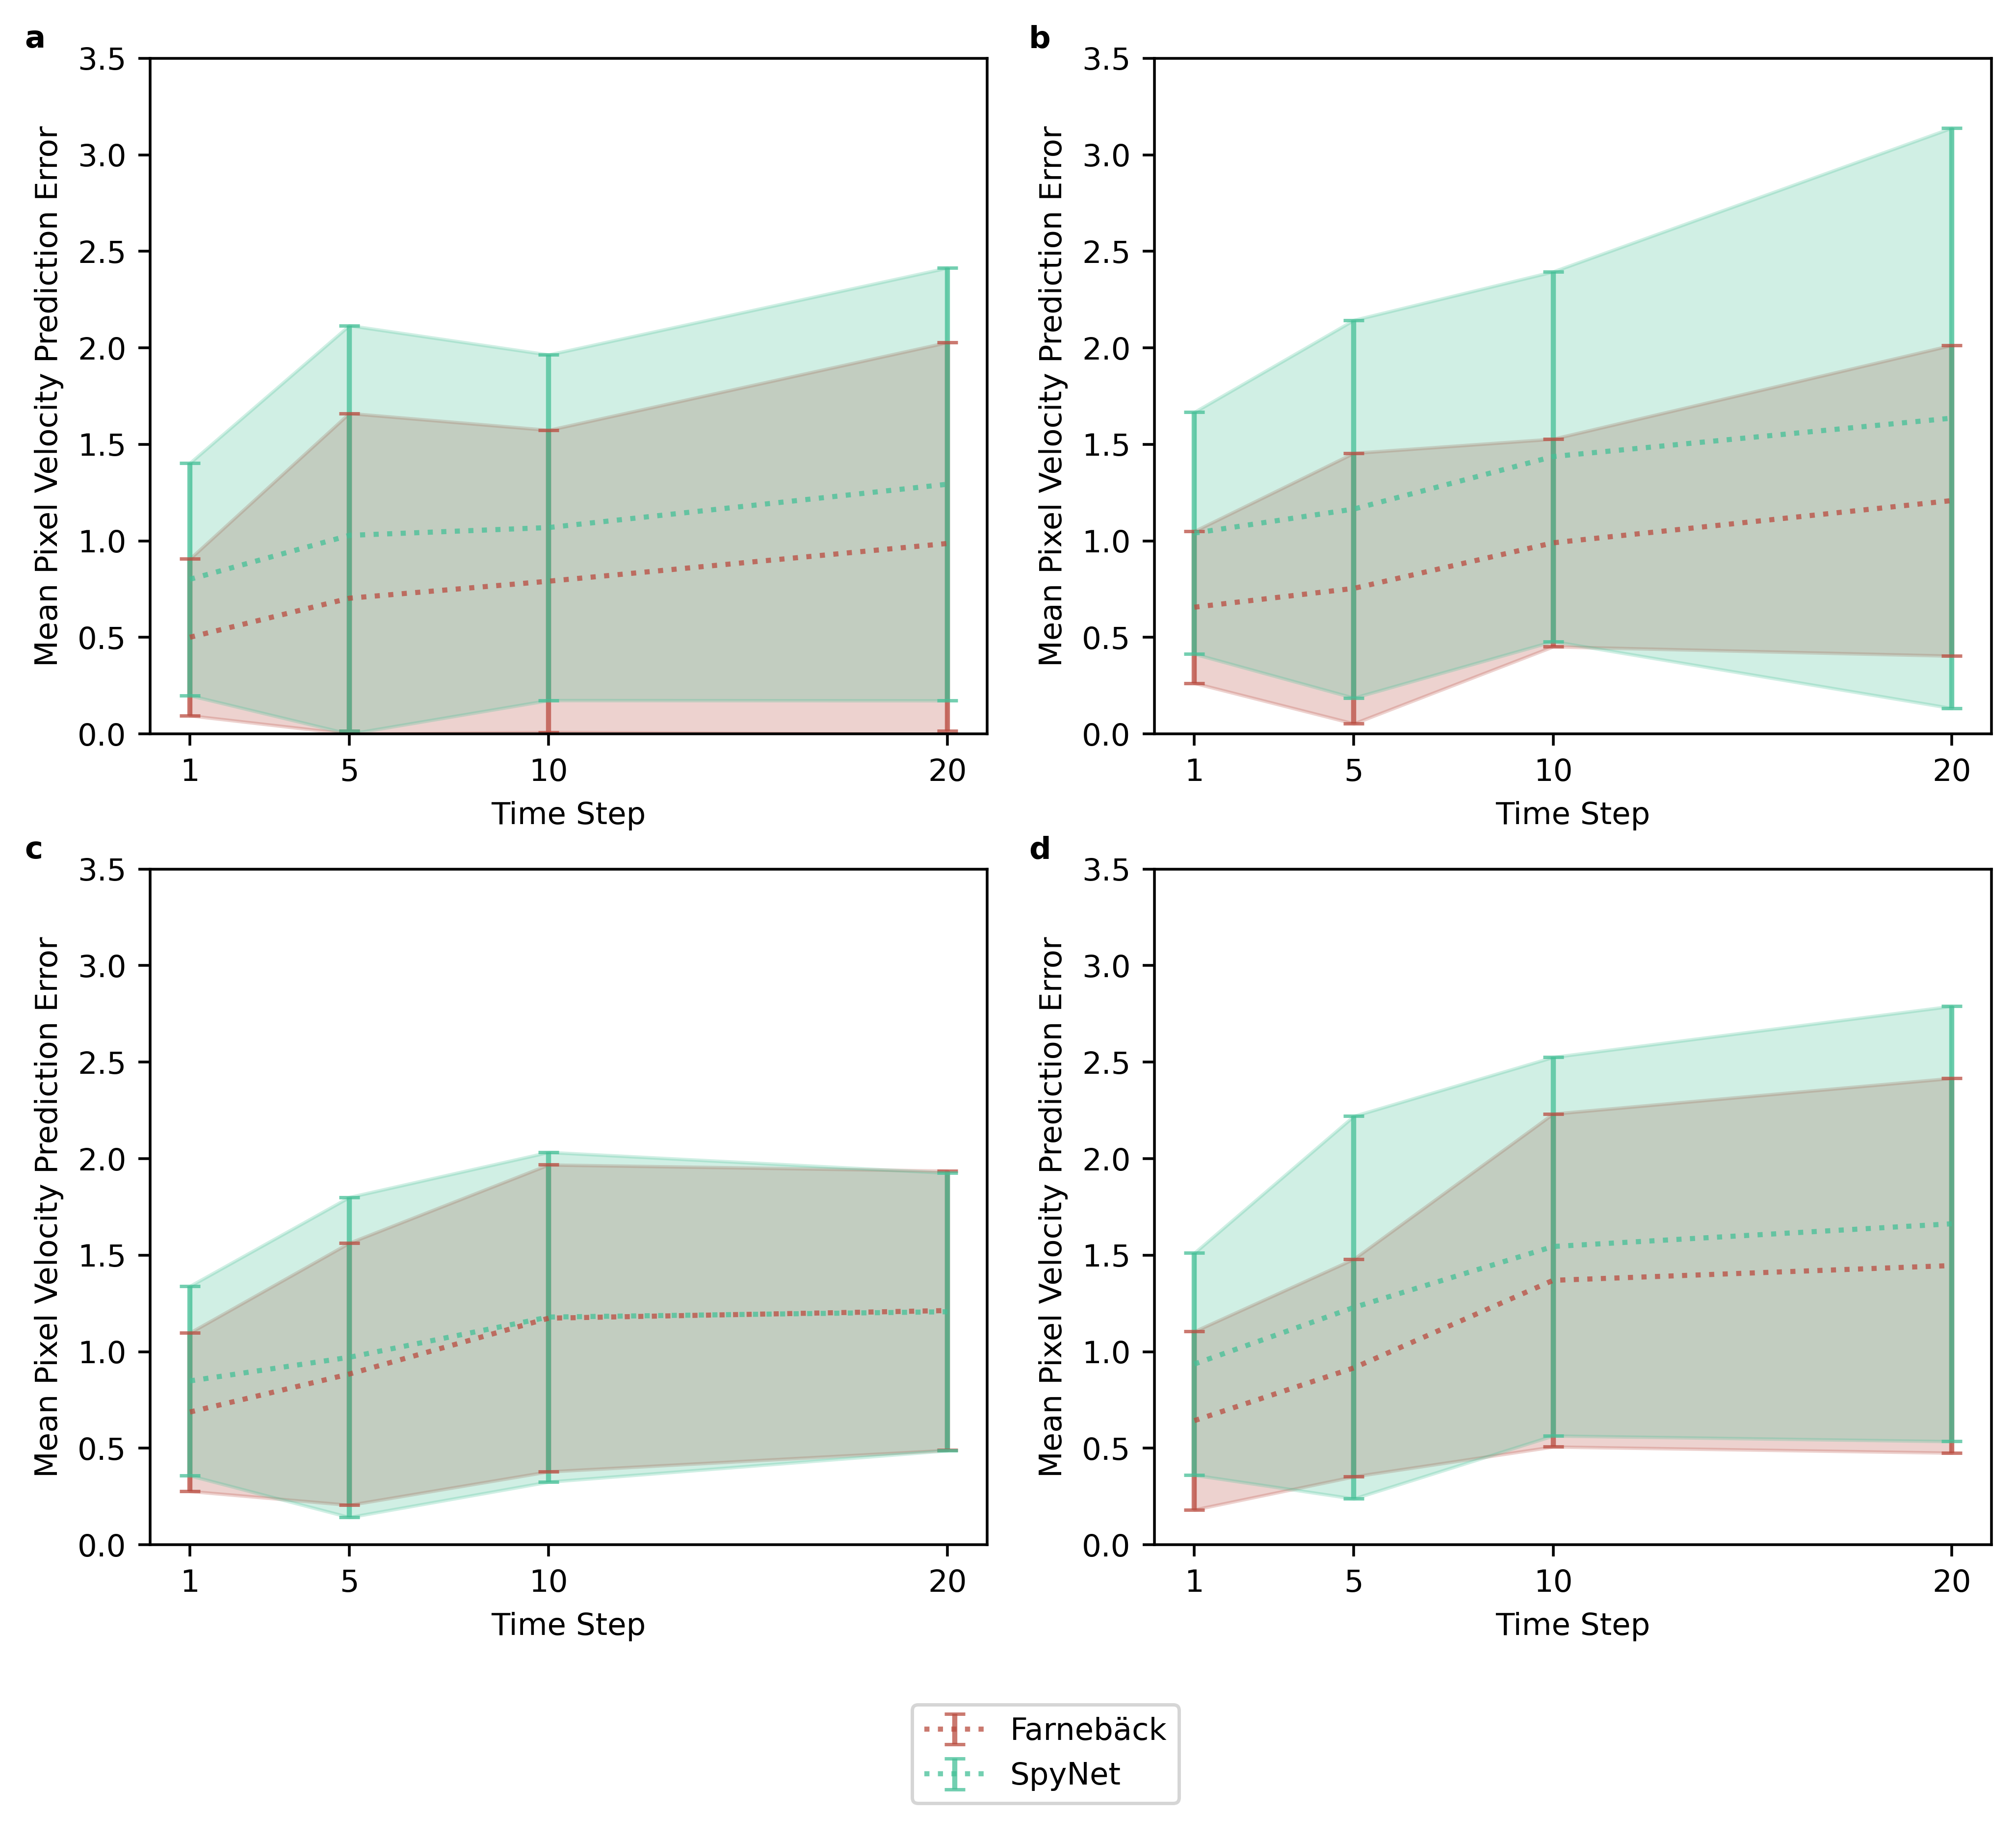

In [8]:
plt.clf()
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=set_size(subplots=(2, 2), width=700, height=600), constrained_layout=True)

plots = [ax1,ax2,ax3,ax4]
ys = [[pm_far, pm_spy], 
          [pf_far, pf_spy], 
          [pmfd_far, pmfd_spy], 
          [pmfi_far, pmfi_spy]]
x = [1,5,10,20]

options = ['Farnebäck', 'SpyNet']

for i in range(4):
    ax = plots[i]
    trans = [Affine2D().translate(-1, 0.0) + ax.transData, Affine2D().translate(+1, 0.0) + ax.transData]
    for j in range(2):
        y = ys[i][j]['pred_vel_ave'][:4]
        e = ys[i][j]['pred_vel_std'][:4]
        #ax.errorbar(x,  y, e, marker=markers[j], label=options[j], color=colors[j], capsize=5, transform=trans[j], linestyle="none")
        e_low, e_high = [(e1 if (y1 - e1 >= 0) else y1-0.015) for y1, e1 in zip(y, e)], [e1 for y1, e1 in zip(y, e)]
        ax.errorbar(x,  y, [e_low, e_high], label=options[j], color=colors[j], alpha=.75, fmt=':', capsize=3, capthick=1)
        data = {
        'x': x,
        'y1': [max(y1 - e1, 0) for y1, e1 in zip(y, e)],
        'y2': [y1 + e1 for y1, e1 in zip(y, e)]}
        ax.fill_between(**data, alpha=.25, color=colors[j])
        ax.legend().remove()
        ax.margins(1)
        ax.set_xlim(0,21)
        ax.set_xticks(x)
        ax.set_ylim(0,3.5)
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Mean Pixel Velocity Prediction Error')
        
ax1.text(-0.15, 1.05, 'a', transform=ax1.transAxes, fontweight='bold', va='top')
ax2.text(-0.15, 1.05, 'b', transform=ax2.transAxes, fontweight='bold', va='top')
ax3.text(-0.15, 1.05, 'c', transform=ax3.transAxes, fontweight='bold', va='top')
ax4.text(-0.15, 1.05, 'd', transform=ax4.transAxes, fontweight='bold', va='top')

h1, l1 = ax1.get_legend_handles_labels()
fig.legend(handles=h1, labels=l1, loc='lower center', bbox_to_anchor=(0.44,0.01))
fig.subplots_adjust(bottom=0.15)


#plt.savefig('fig_main_vel_plot.pdf', format='pdf', bbox_inches='tight')

plt.show()